In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import time
import pathlib
from tensorflow.keras import models, layers, datasets, optimizers
from tensorflow.keras import  Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Add, Activation, MaxPooling2D, Dropout, Flatten, Dense
from datetime import datetime
now = datetime.now() 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = "/content/drive/My Drive/vision/dataset"
os.chdir(data_dir)
#data_dir = pathlib.Path(data_dir)

In [4]:
batch_size = 64

AUTOTUNE = tf.data.experimental.AUTOTUNE


img_height = 256
img_width = 256
print(data_dir)

/content/drive/My Drive/vision/dataset


In [5]:
# Defaults image size to (256, 256)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 1040 files belonging to 2 classes.
Using 832 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 1040 files belonging to 2 classes.
Using 208 files for validation.


In [7]:
class_names = ['covid','non-covid']
print(class_names)

['covid', 'non-covid']


In [8]:
#CONFIFURA PRESTAZIONI

#Assicuriamoci di utilizzare il precaricamento bufferizzato in modo da poter produrre dati dal disco senza che l'I / O si blocchi.
#Questi sono due metodi importanti da utilizzare durante il caricamento dei dati.

#.cache() mantiene le immagini in memoria dopo che sono state caricate dal disco durante la prima epoca
#.prefetch() sovrappone alla preelaborazione dei dati e all'esecuzione del modello durante l'addestramento

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
###############################
#      DATA AUGMENTATION      #
###############################

# Possiamo aggiungere altro

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    #layers.experimental.preprocessing.CenterCrop(25,25),
    #layers.experimental.preprocessing.RandomContrast(samples, height, width, channels) 
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomTranslation(0.1,0.1),
    layers.experimental.preprocessing.RandomZoom(0.2),
    #layers.GaussianNoise(stddev=1)   #standard deviation of noise distribution
  ]
) 

In [10]:
###############################
#          CNN MODEL          #
###############################
#there are no real theoretical rules for which to set the number of filters: 
#they should be tuned like the hyperparameters;
#once you found a good enough functioning, keep them.

model = tf.keras.Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),

  layers.Conv2D(16, 5, padding='valid', activation='relu'),  
  layers.MaxPooling2D((2,2)),
  layers.BatchNormalization(momentum=0.75),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.BatchNormalization(momentum=0.75),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.BatchNormalization(momentum=0.75),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.BatchNormalization(momentum=0.75),

  layers.Dropout(0.5),
  layers.Flatten(),

  #change activation
  layers.Dense(256, activation='relu'),  #first fully connected layers
  
  layers.Dense(2) # 2 is actually our number of classes. #last fully con layer
  
  #nb: If BN is applied to this last layer softmax will produce slightly different values and thus predictions have low accuracy


])

#LR DECAY with STOCASTIC GRAD DESCENT
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.SGD(learning_rate=lr_schedule)


#opt = optimizers.Adam(learning_rate=0.0001) #da provare poi cosi

model.compile(
  optimizer=opt,
  loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),	 #set TRUE may be more numerically stable.
  #loss= tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

#checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'check', monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
print(model.summary())

print(len(list(dataset)))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 252, 252, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)       

In [11]:
epochs = 100

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  #callbacks=checkpointer,
  batch_size=batch_size,
  shuffle = 1040
)

model.save('model.h5')

Epoch 1/100
13/13 [==============================] - 255s 20s/step - loss: 0.5589 - accuracy: 0.8606 - val_loss: 2.3882 - val_accuracy: 0.4615
Epoch 2/100
13/13 [==============================] - 3s 197ms/step - loss: 0.1540 - accuracy: 0.9411 - val_loss: 0.1110 - val_accuracy: 0.9663
Epoch 3/100
13/13 [==============================] - 3s 197ms/step - loss: 0.1073 - accuracy: 0.9639 - val_loss: 0.0979 - val_accuracy: 0.9760
Epoch 4/100
13/13 [==============================] - 3s 198ms/step - loss: 0.0495 - accuracy: 0.9820 - val_loss: 0.0870 - val_accuracy: 0.9615
Epoch 5/100
13/13 [==============================] - 3s 199ms/step - loss: 0.0969 - accuracy: 0.9675 - val_loss: 0.0405 - val_accuracy: 0.9856
Epoch 6/100
13/13 [==============================] - 3s 197ms/step - loss: 0.0524 - accuracy: 0.9760 - val_loss: 0.0450 - val_accuracy: 0.9760
Epoch 7/100
13/13 [==============================] - 3s 197ms/step - loss: 0.0437 - accuracy: 0.9856 - val_loss: 0.0774 - val_accuracy: 0.9760

Text(0.5, 1.0, 'Training and Validation Loss')

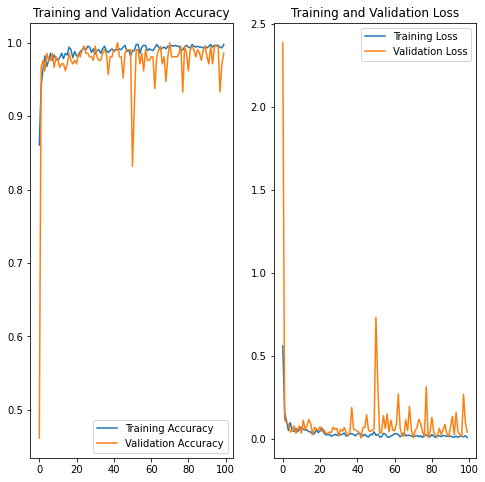

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig()

In [35]:

class_names = ['covid','non-covid']
print(class_names)

dataset_covid = "/content/drive/My Drive/vision/test/covid"
data_dir_covid = pathlib.Path(dataset_covid)


# create a list of elems
positives = list(data_dir_covid.glob('*'))

predictions_list = []

true_positive = 0
false_positive = 0

for i in positives:
  # read the image
  img = keras.preprocessing.image.load_img(str(i), target_size=(256, 256))
  # trasform into array
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  # apply your inference here
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  #class_predict = tf.nn.sigmoid_cross_entropy_with_logits(labels=1, logits=np.max(predictions[0]))
  #print(np.max(class_predict))
  
  if np.argmax(score) == 0:
    true_positive = true_positive + 1 #true positive
  
  
false_positive = 50-true_positive






['covid', 'non-covid']
7


In [ ]:

class_names = ['covid','non-covid']
print(class_names)


dataset_nocovid = "/content/drive/My Drive/vision/test/non"
data_dir_nocovid = pathlib.Path(dataset_nocovid)

# create a list of elems
positives = list(data_dir_covid.glob('*'))
negatives = list(data_dir_nocovid.glob('*'))

predictions_list = []

true_negative = 0
false_negative = 0


for j in negatives:
  # read the image
  img = keras.preprocessing.image.load_img(str(j), target_size=(256, 256))
  # trasform into array
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  # apply your inference here
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  #class_predict = tf.nn.sigmoid_cross_entropy_with_logits(labels=1, logits=np.max(predictions[0]))
  #print(np.max(class_predict))
  print(np.argmax(score))
  if np.argmax(score) == 1:
    true_negative = true_negative + 1 #true negative.  non covid
  
  
false_negative = 50-true_negative




In [43]:

print("true postive = ", true_positive)
print("true negative = ", true_negative)
print("false postive = ", false_positive)
print("false negative = ", false_negative)

true postive =  43
true negative =  50
false postive =  7
false negative =  0


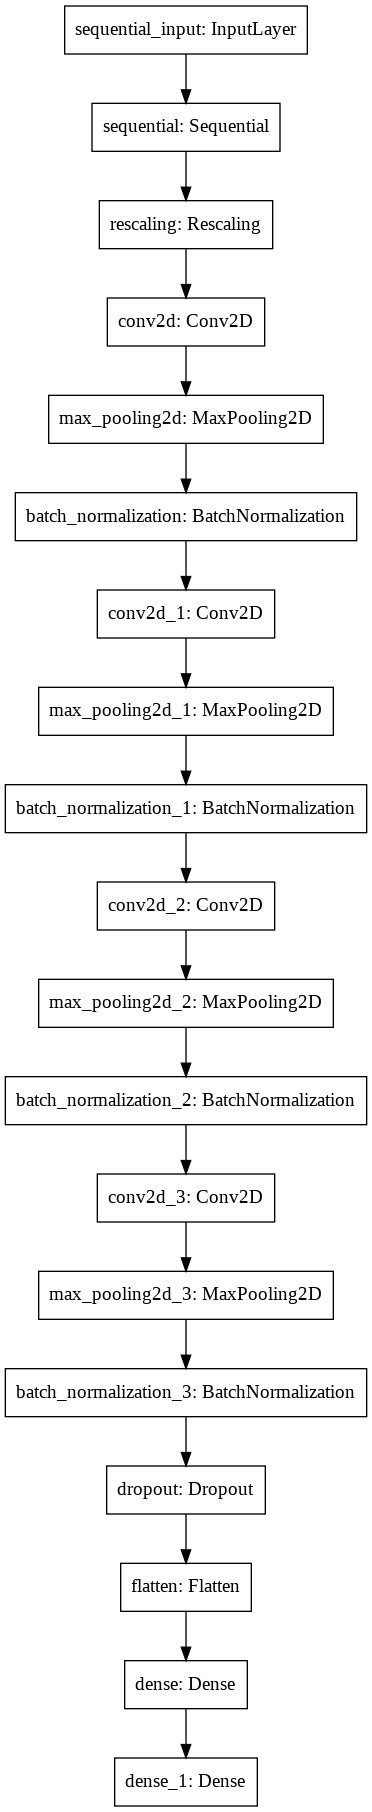

In [44]:
tf.keras.utils.plot_model(model, to_file="deep_model.png")